In [9]:
import sys
sys.path.append('../')

import numpy as np
import numba as nb
import matplotlib.pyplot as plt
import pandas as pd
import jsonpickle

from particle_filter import particlefilter
from pmcmc import particlemcmc
from math_utils import nbinom_logpmf

In [10]:
'''Import data'''

data = pd.read_csv('../data_sets/ou_SIRS_data_nbinom.csv').to_numpy()
state = pd.read_csv('../data_sets/ou_SIRS_state_nbinom.csv').to_numpy()
betas = pd.read_csv('../data_sets/ou_SIRS_betas_nbinom.csv').to_numpy()

In [11]:
def SIRS_model(particles,observations,t,dt,model_params,rng):
    '''Definition of SEIR model as described in Calvetti's paper. Difference 
    is the use of Tau leaping to introduce stochasticity into the system and continuous log-normal OU process definition for beta.'''
    gamma,xi,sig,mu,R = model_params

    lam = 1/100

    A = np.exp(-lam * dt)
    M = mu * (np.exp(-lam * dt) - 1)
    C = sig * np.sqrt(1 - np.exp(-2 * lam * dt))

    '''Tau leaping. Non estimated parameters are hard coded. '''

    for index in range(particles.shape[0]):

        new_I = rng.poisson((particles[index,3,t] * particles[index, 1, t]* particles[index, 0, t])/np.sum(particles[index,:,t]) * dt)
        new_S = rng.poisson((xi * particles[index,2,t]) * dt)
        new_R = rng.poisson((gamma * particles[index,1,t]) * dt)

        particles[index,0,t] = np.maximum(0.,particles[index,0,t] - new_I + new_S) #S
        particles[index,1,t] = np.maximum(0.,particles[index,1,t] + new_I - new_R) #I
        particles[index,2,t] = np.maximum(0.,particles[index,2,t] + new_R-new_S) #R

        particles[index,3,t] = np.exp(A * np.log(particles[index,3,t]) - M + C * rng.standard_normal())

        observations[index,0,t] = particles[index,1,t]

    return particles,observations

def SIRS_Obs(data_point, particle_observations, model_params):
    r = 1/model_params[4]
    weights = nbinom_logpmf(x = data_point,p = r/(r + particle_observations[:,0] + 0.005),n = np.array([r]))
    return weights


In [12]:
'''True parameter values'''
rng = np.random.default_rng(0)

'''unpickle parameter sets'''
with open("../param_sets/SIRS_OU_model_params.json", "r+") as f:
    SIRS_model_json = f.read()
    SIRS_model_params = jsonpickle.decode(SIRS_model_json)

gamma = SIRS_model_params['gamma']
R = SIRS_model_params['R']
xi = SIRS_model_params['xi']

with open("../param_sets/SIRS_OU_process_params.json", "r+") as f:
    OU_process_json = f.read()
    SIRS_OU_process_params = jsonpickle.decode(OU_process_json)

mean_ou = SIRS_OU_process_params['mean_ou']
sig = SIRS_OU_process_params['sig']

T = 365
dt = 0.1
t_vec = np.arange(0,T,dt)

def SIRS_init(num_particles, model_dim, rng):
    particles_0 = np.zeros((num_particles,model_dim))
    particles_0[:,0] = 500
    I_init = rng.integers(1,5,size = (num_particles))
    particles_0[:,0] -= I_init
    particles_0[:,1] = I_init
    particles_0[:,3] = rng.uniform(0.,1., size = (num_particles,))
    

    return particles_0

pf_params = {'num_particles':10_000, 
                      'dt':dt,
                      'model':SIRS_model,
                      'observation_model':SIRS_Obs,
                      'model_dim':4,
                      'particle_initializer':SIRS_init,
                      }

from time import perf_counter

t = perf_counter()
output = particlefilter(data = data,
        model_params= (gamma,xi,sig,mean_ou,1/R),
        pf_params = pf_params,
        rng = rng,
        req_jit=True
        )

print(perf_counter() - t)

9.437358886993024


 Log Likelihood : -1445.510854341815
Root Mean Squared Error for the Data 24.690421416250388


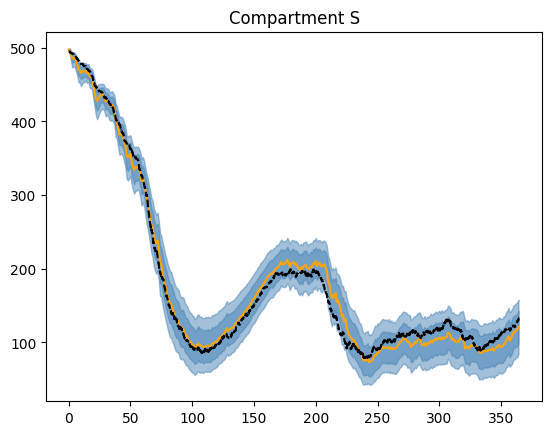

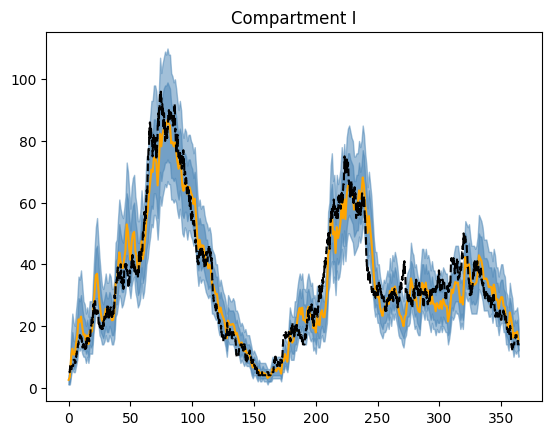

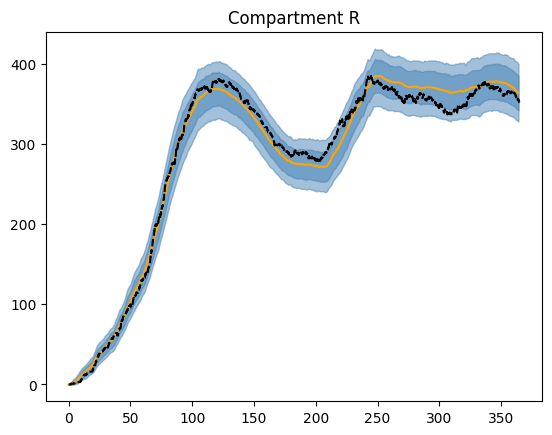

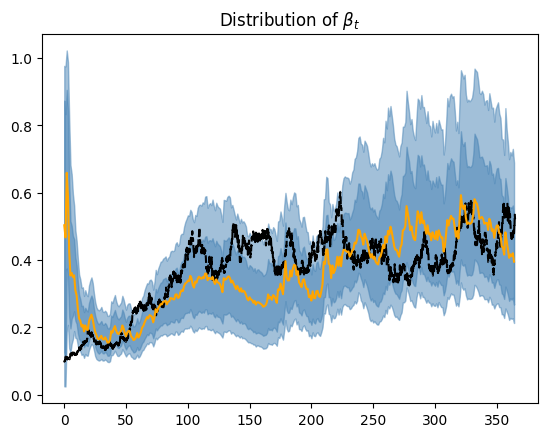

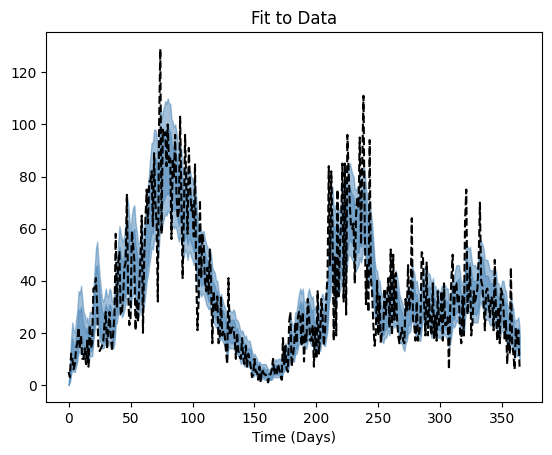

In [13]:
print(f" Log Likelihood : {np.sum(output['Log_likelihood'])}")

print(f"Root Mean Squared Error for the Data {np.sqrt(np.mean((data - np.mean(output['particle_observations'][:,0,:]))**2))}")

labels = ['S','I','R']
for i in range(3):
    plt.title(f'Compartment {labels[i]}')
    plt.fill_between(t_vec[::int(1/dt)],np.percentile(output['particle_distribution'][:,i,:].T,2.5,axis = 1),np.percentile(output['particle_distribution'][:,i,:].T,97.5,axis = 1),alpha = 0.5,color = 'steelblue')
    plt.fill_between(t_vec[::int(1/dt)],np.percentile(output['particle_distribution'][:,i,:].T,12.5,axis = 1),np.percentile(output['particle_distribution'][:,i,:].T,87.5,axis = 1),alpha = 0.5,color = 'steelblue')
    plt.plot(np.average(output['particle_distribution'][:,i,:],weights = np.exp(output['log_weights']),axis = 0),color = 'orange')
    plt.plot(t_vec,state[i,:].T,'--',color = 'black')
    plt.show()

plt.title('Distribution of $\\beta_t$')
plt.plot(t_vec,betas,'--',color = 'black')
plt.fill_between(t_vec[::int(1/dt)],np.percentile(output['particle_distribution'][:,3,:].T,2.5,axis = 1),np.percentile(output['particle_distribution'][:,3,:].T,97.5,axis = 1),alpha = 0.5,color = 'steelblue')
plt.fill_between(t_vec[::int(1/dt)],np.percentile(output['particle_distribution'][:,3,:].T,12.5,axis = 1),np.percentile(output['particle_distribution'][:,3,:].T,87.5,axis = 1),alpha = 0.5,color = 'steelblue')
plt.plot(np.average(output['particle_distribution'][:,3,:],weights = np.exp(output['log_weights']),axis = 0),color = 'orange')
plt.show()

plt.title("Fit to Data")
plt.xlabel('Time (Days)')
plt.plot(t_vec[::int(1/dt)],data.T,'--',color = 'black')
plt.fill_between(t_vec[::int(1/dt)],np.percentile(output['particle_observations'][:,0,:].T,2.5,axis = 1),np.percentile(output['particle_observations'][:,0,:].T,97.5,axis = 1),alpha = 0.5,color = 'steelblue')
plt.fill_between(t_vec[::int(1/dt)],np.percentile(output['particle_observations'][:,0,:].T,12.5,axis = 1),np.percentile(output['particle_observations'][:,0,:].T,87.5,axis = 1),alpha = 0.5,color = 'steelblue')
plt.show()

In [14]:
pmcmc_rng = np.random.default_rng(100)

@nb.njit
def uniform_numba_logpdf(theta,min_val,max_val):

    if(theta < max_val and theta > min_val):
        return np.log(1/(max_val - min_val))
    
    return np.log(0.)

def sirs_prior(theta):
    return uniform_numba_logpdf(theta[0],min_val= 1/28.,max_val= 1/7) + \
    uniform_numba_logpdf(theta[1],min_val = 1/365.,max_val = 1/10.) + \
    uniform_numba_logpdf(theta[2],min_val=0.,max_val=1.) + \
    uniform_numba_logpdf(theta[3],min_val = -2.,max_val=0.) + \
    uniform_numba_logpdf(theta[4],min_val = 0.,max_val=1/2)


'''estimated params gamma,xi,sig,mean_ou,1/R 
0.1 0.008333333333333333 0.05 -1.0 0.1'''

pmcmc_params = {'iterations':50_000,
                'init_params':np.array([0.1,0.1,0.1,-0.7,0.01]),
                'prior':sirs_prior,
                'init_cov':  np.diag([0.01,0.01,0.01,0.01,0.01]),
                'burn_in':1_000}

pf_params = {'num_particles':1000, 
                      'dt':1.,
                      'model':SIRS_model,
                      'observation_model':SIRS_Obs,
                      'model_dim':5,
                      'particle_initializer':SIRS_init
                      }

t = perf_counter()
pmcmc_output = particlemcmc(
                  data = data,
                  pmcmc_params=pmcmc_params,
                  pf_params=pf_params,
                  adaptive=True,
                  rng = rng,
                  req_jit=True
                  )
print(perf_counter() - t)

/Users/averydrennan/PMCMC/examples/../pmcmc.py:117: RuntimeWarning: invalid value encountered in scalar subtract
  ratio = (LL_new - LL[iter-1])


iteration: 10| Acceptance rate: 0.1| Log-Likelihood: -1685.2127752761667| Proposal [ 0.03806374  0.03184924  0.23640559 -0.80677793  0.06766414]
iteration: 20| Acceptance rate: 0.1| Log-Likelihood: -1570.8032233877711| Proposal [ 0.0779918   0.09927718  0.19908809 -0.66788911  0.21499487]
iteration: 30| Acceptance rate: 0.1| Log-Likelihood: -1551.213869601324| Proposal [ 0.12591255  0.09046095  0.11457689 -0.74190772  0.20397169]
iteration: 40| Acceptance rate: 0.075| Log-Likelihood: -1551.213869601324| Proposal [ 0.12591255  0.09046095  0.11457689 -0.74190772  0.20397169]
iteration: 50| Acceptance rate: 0.08| Log-Likelihood: -1526.8526368771668| Proposal [ 0.07181743  0.0036051   0.21488847 -0.84788156  0.44070605]
iteration: 60| Acceptance rate: 0.06666666666666667| Log-Likelihood: -1526.8526368771668| Proposal [ 0.07181743  0.0036051   0.21488847 -0.84788156  0.44070605]
iteration: 70| Acceptance rate: 0.05714285714285714| Log-Likelihood: -1526.8526368771668| Proposal [ 0.07181743  

-1437.0901533834801
The Maximum Likelihood Estimate is [ 0.08762043  0.00659481  0.11522699 -0.5043587   0.12309178] w/ LL of -1437.0901533834801


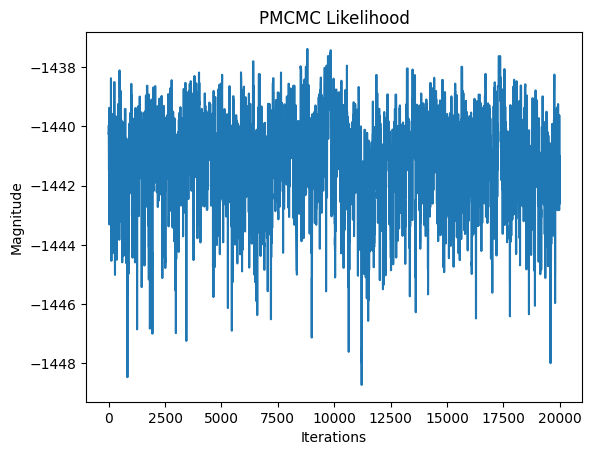

In [22]:
burn_in = 30000

MLE = np.argmax(pmcmc_output['Log Likelihood'])

print(pmcmc_output['Log Likelihood'][MLE])

print(f"The Maximum Likelihood Estimate is {pmcmc_output['accepted_params'][:,MLE]} w/ LL of {pmcmc_output['Log Likelihood'][MLE]}")

plt.title("PMCMC Likelihood")
plt.ylabel("Magnitude")
plt.xlabel("Iterations")
plt.plot(pmcmc_output['Log Likelihood'][burn_in:])

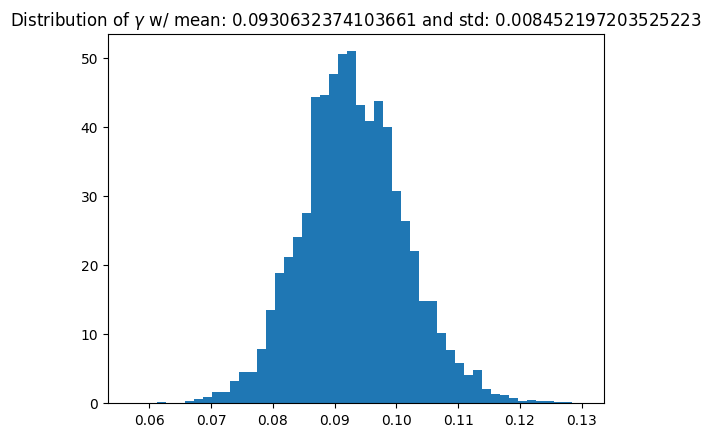

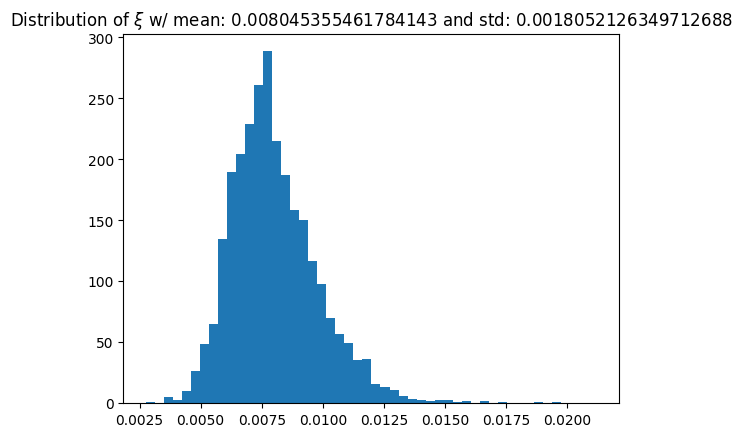

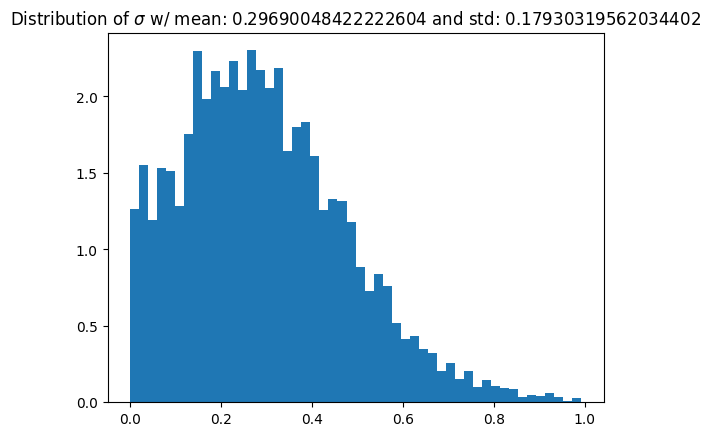

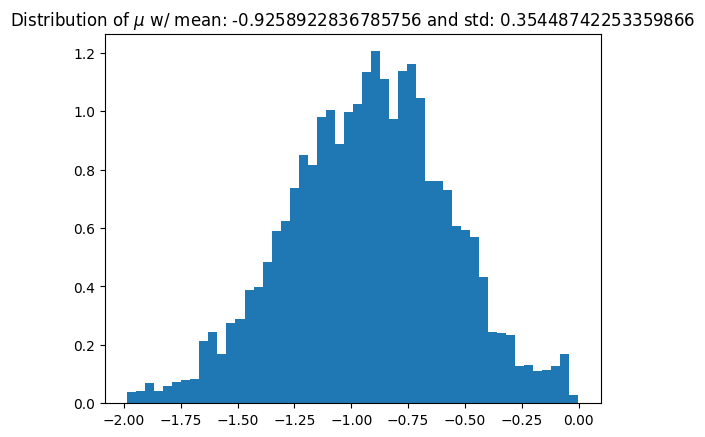

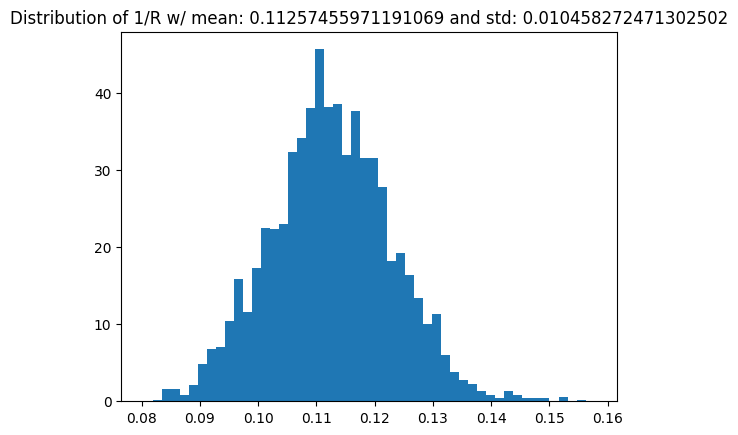

In [23]:
plt.title(f"Distribution of $\\gamma$ w/ mean: {np.mean(pmcmc_output['accepted_params'][0,burn_in:])} and std: {np.std(pmcmc_output['accepted_params'][0,burn_in:])}")
plt.hist(pmcmc_output['accepted_params'][0,burn_in:],density=True,bins = 50)
plt.show()

plt.title(f"Distribution of $\\xi$ w/ mean: {np.mean((pmcmc_output['accepted_params'][1,burn_in:]))} and std: {np.std((pmcmc_output['accepted_params'][1,burn_in:]))}")
plt.hist((pmcmc_output['accepted_params'][1,burn_in:]),density=True,bins = 50)
plt.show()

plt.title(f"Distribution of $\\sigma$ w/ mean: {np.mean((pmcmc_output['accepted_params'][2,burn_in:]))} and std: {np.std((pmcmc_output['accepted_params'][2,burn_in:]))}")
plt.hist((pmcmc_output['accepted_params'][2,burn_in:]),density=True,bins = 50)
plt.show()

plt.title(f"Distribution of $\\mu$ w/ mean: {np.mean((pmcmc_output['accepted_params'][3,burn_in:]))} and std: {np.std((pmcmc_output['accepted_params'][3,burn_in:]))}")
plt.hist((pmcmc_output['accepted_params'][3,burn_in:]),density=True,bins = 50)
plt.show()

plt.title(f"Distribution of 1/R w/ mean: {np.mean((pmcmc_output['accepted_params'][4,burn_in:]))} and std: {np.std((pmcmc_output['accepted_params'][4,burn_in:]))}")
plt.hist((pmcmc_output['accepted_params'][4,burn_in:]),density=True,bins = 50)
plt.show()

In [24]:
par = np.mean((pmcmc_output['accepted_params'][:,burn_in:]),axis = 1)

pf_params = {'num_particles':10_000, 
                      'dt':dt,
                      'model':SIRS_model,
                      'observation_model':SIRS_Obs,
                      'model_dim':4,
                      'particle_initializer':SIRS_init,
                      }

from time import perf_counter

t = perf_counter()
output = particlefilter(data = data,
        model_params= par,
        pf_params = pf_params,
        rng = rng,
        req_jit=True
        )

print(perf_counter() - t)

8.554033488006098


 Log Likelihood : -1444.189580016519
Root Mean Squared Error for the Data 24.691486740583375


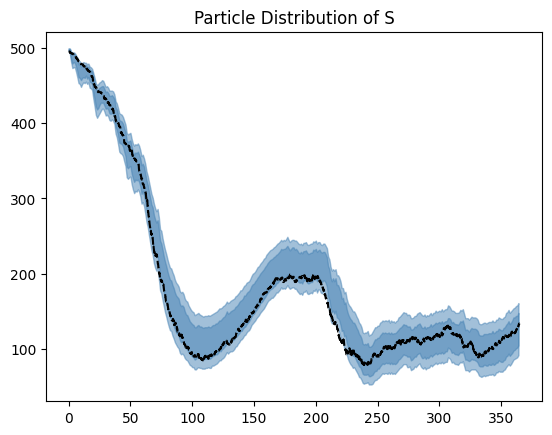

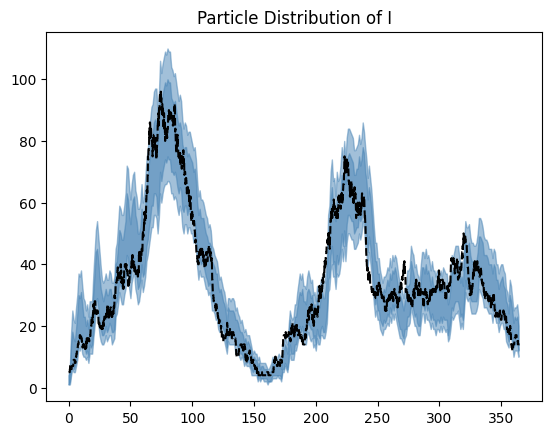

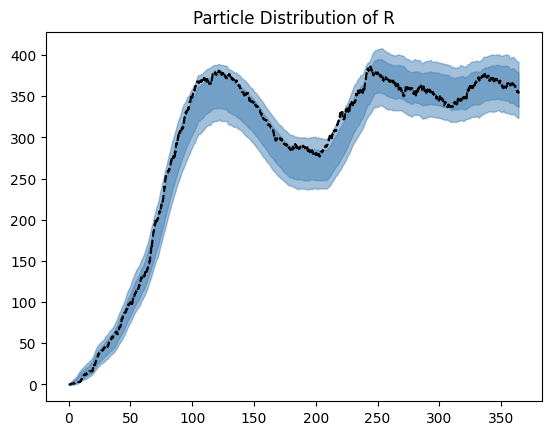

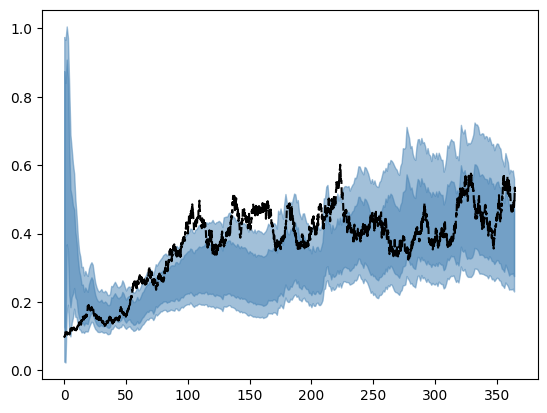

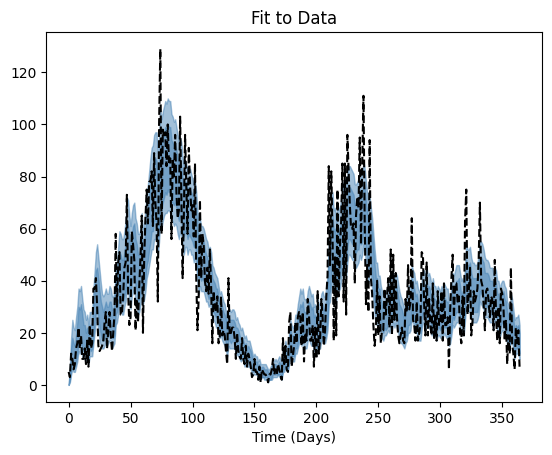

In [25]:
'''Plots using the Expectation of the parameters and running the filter. '''
print(f" Log Likelihood : {np.sum(output['Log_likelihood'])}")
print(f"Root Mean Squared Error for the Data {np.sqrt(np.mean((data - np.mean(output['particle_observations'][:,0,:]))**2))}")

dt = pf_params['dt']
Labels = ['S','I','R']
for i in range(3):
    plt.title(f"Particle Distribution of {Labels[i]}")
    plt.fill_between(t_vec[::int(1/dt)],np.percentile(output['particle_distribution'][:,i,:].T,2.5,axis = 1),np.percentile(output['particle_distribution'][:,i,:].T,97.5,axis = 1),alpha = 0.5,color = 'steelblue')
    plt.fill_between(t_vec[::int(1/dt)],np.percentile(output['particle_distribution'][:,i,:].T,12.5,axis = 1),np.percentile(output['particle_distribution'][:,i,:].T,87.5,axis = 1),alpha = 0.5,color = 'steelblue')
    plt.plot(t_vec,state[i,:].T,'--',color = 'black')
    plt.show()

plt.plot(t_vec,betas,'--',color = 'black')
plt.fill_between(t_vec[::int(1/dt)],np.percentile(output['particle_distribution'][:,3,:].T,2.5,axis = 1),np.percentile(output['particle_distribution'][:,3,:].T,97.5,axis = 1),alpha = 0.5,color = 'steelblue')
plt.fill_between(t_vec[::int(1/dt)],np.percentile(output['particle_distribution'][:,3,:].T,12.5,axis = 1),np.percentile(output['particle_distribution'][:,3,:].T,87.5,axis = 1),alpha = 0.5,color = 'steelblue')
plt.show()

plt.title("Fit to Data")
plt.xlabel('Time (Days)')
plt.plot(t_vec[::int(1/dt)],data.T,'--',color = 'black')
plt.fill_between(t_vec[::int(1/dt)],np.percentile(output['particle_observations'][:,0,:].T,2.5,axis = 1),np.percentile(output['particle_observations'][:,0,:].T,97.5,axis = 1),alpha = 0.5,color = 'steelblue')
plt.fill_between(t_vec[::int(1/dt)],np.percentile(output['particle_observations'][:,0,:].T,12.5,axis = 1),np.percentile(output['particle_observations'][:,0,:].T,87.5,axis = 1),alpha = 0.5,color = 'steelblue')
plt.show()

In [19]:
np.savez('../pmcmc_output/SIRS_pmcmc_output.npz',
accepted_params = pmcmc_output['accepted_params'],
log_likelihood=pmcmc_output['Log Likelihood'],
MLE_particle_dist = pmcmc_output['MLE_particle_dist'],
MLE_particle_observations = pmcmc_output['MLE_particle_observations'])